# Домашняя работа №7

In [59]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Настройки визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.utils import resample

## Датасет 1

In [57]:
RANDOM_STATE = 42

In [9]:
df_1 = pd.read_csv('data/S07-hw-dataset-01.csv')
df_1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [10]:
df_1.shape

(12000, 9)

In [11]:
df_1.info() # все признаки числовые

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [12]:
df_1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [15]:
df_1.isna().sum() # нет пропусков

sample_id    0
f01          0
f02          0
f03          0
f04          0
f05          0
f06          0
f07          0
f08          0
dtype: int64

In [16]:
X_df1 = df_1.drop(columns=['sample_id'])
sampleId_df1 = df_1['sample_id']
X_df1.shape, sampleId_df1.shape

((12000, 8), (12000,))

In [19]:
scaler = StandardScaler() # Стандартизация
X_df1_scaled = scaler.fit_transform(X_df1)
X_df1_scaled

array([[ 0.17142668, -1.46280499,  0.43827875, ..., -0.89591542,
        -0.11539556, -0.84301268],
       [ 1.60302144,  0.55306178, -2.1005838 , ...,  2.2545476 ,
        -0.83142723,  0.6304788 ],
       [ 1.90373017,  0.95758263, -2.19656934, ...,  1.68513022,
         0.74843886,  0.52428406],
       ...,
       [-0.46746486,  0.83750509,  0.12423596, ..., -0.42714879,
        -1.65916612,  1.36483461],
       [ 1.47828378,  1.1389387 , -2.41291263, ...,  1.91602935,
        -0.33375476,  0.48180103],
       [-1.16571448, -0.849189  ,  0.87345715, ...,  0.09937317,
        -1.7957767 , -0.92784466]])

In [61]:
def load_and_explore_dataset(filepath, dataset_name):
    """Загрузка и базовый анализ датасета"""
    print(f"\n{'='*60}")
    print(f"Анализ датасета: {dataset_name}")
    print(f"{'='*60}")
    
    df = pd.read_csv(filepath)
    
    print("1. Первые 5 строк:")
    print(df.head())
    
    print(f"\n2. Информация о датасете:")
    print(df.info())
    
    print(f"\n3. Базовые статистики:")
    print(df.describe())
    
    print(f"\n4. Пропуски:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "Пропусков нет")
    
    print(f"\n5. Типы признаков:")
    for col in df.columns:
        if col != 'sample_id':
            dtype = df[col].dtype
            unique = df[col].nunique() if dtype == 'object' else 'числовой'
            print(f"  {col}: {dtype} ({unique})")
    
    return df

def create_preprocessor(df, categorical_cols=None):
    """Создание пайплайна для препроцессинга"""
    if categorical_cols is None:
        categorical_cols = []
    
    numeric_cols = [col for col in df.columns 
                    if col != 'sample_id' and col not in categorical_cols]
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    if categorical_cols:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols)
            ])
    
    return preprocessor

def evaluate_kmeans(X, dataset_name, k_range=range(2, 21)):
    """Оценка KMeans для разных значений k"""
    results = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            metrics = {
                'k': k,
                'inertia': kmeans.inertia_,
                'silhouette': silhouette_score(X, labels),
                'davies_bouldin': davies_bouldin_score(X, labels),
                'calinski_harabasz': calinski_harabasz_score(X, labels)
            }
            results.append(metrics)
    
    results_df = pd.DataFrame(results)
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(results_df['k'], results_df['inertia'], marker='o')
    axes[0, 0].set_title('Inertia vs K')
    axes[0, 0].set_xlabel('K')
    axes[0, 0].set_ylabel('Inertia (ниже лучше)')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(results_df['k'], results_df['silhouette'], marker='o', color='green')
    axes[0, 1].set_title('Silhouette Score vs K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Silhouette (выше лучше)')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(results_df['k'], results_df['davies_bouldin'], marker='o', color='red')
    axes[1, 0].set_title('Davies-Bouldin Index vs K')
    axes[1, 0].set_xlabel('K')
    axes[1, 0].set_ylabel('DB Index (ниже лучше)')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(results_df['k'], results_df['calinski_harabasz'], marker='o', color='purple')
    axes[1, 1].set_title('Calinski-Harabasz Score vs K')
    axes[1, 1].set_xlabel('K')
    axes[1, 1].set_ylabel('CH Score (выше лучше)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'KMeans Metrics for {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/kmeans_metrics_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return results_df

def evaluate_dbscan(X, dataset_name, eps_values=None, min_samples=5):
    """Оценка DBSCAN с разными параметрами eps"""
    if eps_values is None:
        # Автоматический подбор диапазона eps через k-distance plot
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors.fit(X)
        distances, _ = neighbors.kneighbors(X)
        k_distances = np.sort(distances[:, -1])
        
        eps_range = np.linspace(k_distances[5], k_distances[-5], 10)
    else:
        eps_range = eps_values
    
    results = []
    
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)
        
        metrics = {
            'eps': eps,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio
        }
        
        # Расчет метрик только для нешумовых точек с >=2 кластерами
        non_noise_mask = labels != -1
        if n_clusters >= 2 and np.sum(non_noise_mask) > 0:
            X_non_noise = X[non_noise_mask]
            labels_non_noise = labels[non_noise_mask]
            
            metrics.update({
                'silhouette': silhouette_score(X_non_noise, labels_non_noise),
                'davies_bouldin': davies_bouldin_score(X_non_noise, labels_non_noise),
                'calinski_harabasz': calinski_harabasz_score(X_non_noise, labels_non_noise)
            })
        else:
            metrics.update({
                'silhouette': None,
                'davies_bouldin': None,
                'calinski_harabasz': None
            })
        
        results.append(metrics)
    
    results_df = pd.DataFrame(results)
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(results_df['eps'], results_df['n_clusters'], marker='o')
    axes[0, 0].set_title('Number of Clusters vs eps')
    axes[0, 0].set_xlabel('eps')
    axes[0, 0].set_ylabel('Number of Clusters')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(results_df['eps'], results_df['noise_ratio'], marker='o', color='red')
    axes[0, 1].set_title('Noise Ratio vs eps')
    axes[0, 1].set_xlabel('eps')
    axes[0, 1].set_ylabel('Noise Ratio')
    axes[0, 1].grid(True, alpha=0.3)
    
    if results_df['silhouette'].notna().any():
        axes[1, 0].plot(results_df['eps'], results_df['silhouette'], marker='o', color='green')
        axes[1, 0].set_title('Silhouette Score vs eps')
        axes[1, 0].set_xlabel('eps')
        axes[1, 0].set_ylabel('Silhouette')
        axes[1, 0].grid(True, alpha=0.3)
    
    if results_df['calinski_harabasz'].notna().any():
        axes[1, 1].plot(results_df['eps'], results_df['calinski_harabasz'], marker='o', color='purple')
        axes[1, 1].set_title('Calinski-Harabasz Score vs eps')
        axes[1, 1].set_xlabel('eps')
        axes[1, 1].set_ylabel('CH Score')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'DBSCAN Metrics for {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/dbscan_metrics_{dataset_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return results_df

def plot_pca_results(X, labels, dataset_name, title_suffix=""):
    """Визуализация результатов кластеризации в PCA пространстве"""
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    
    # Создание цветовой карты для кластеров
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Scatter plot с кластерами
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=labels, cmap='tab20', s=30, alpha=0.8)
    ax1.set_title(f'PCA - {dataset_name} {title_suffix}')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax1.grid(True, alpha=0.3)
    
    # Добавление легенды для кластеров
    if n_clusters <= 20:
        legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=plt.cm.tab20(i), 
                                  markersize=10, label=f'Cluster {label}')
                          for i, label in enumerate(unique_labels)]
        ax1.legend(handles=legend_elements, title='Clusters', 
                  bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Scatter plot с окраской по плотности (для DBSCAN)
    if -1 in labels:  # Если есть шум
        noise_mask = labels == -1
        cluster_mask = ~noise_mask
        
        ax2.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
                   c=labels[cluster_mask], cmap='tab20', s=30, alpha=0.8, label='Clusters')
        ax2.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
                   c='gray', s=15, alpha=0.5, marker='x', label='Noise')
        ax2.legend()
    else:
        ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', s=30, alpha=0.8)
    
    ax2.set_title(f'PCA with Noise Highlight - {dataset_name}')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'PCA Visualization for {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/pca_{dataset_name}_{title_suffix.replace(" ", "_")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.2%}")
    return X_pca

def calculate_all_metrics(X, labels, algorithm_name):
    """Расчет всех метрик качества"""
    metrics = {}
    
    # Статистика по кластерам
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_count = np.sum(labels == -1)
    
    metrics['algorithm'] = algorithm_name
    metrics['n_clusters'] = int(n_clusters)
    metrics['noise_points'] = int(noise_count)
    metrics['noise_ratio'] = float(noise_count / len(labels))
    
    # Расчет метрик на нешумовых точках
    non_noise_mask = labels != -1
    if n_clusters >= 2 and np.sum(non_noise_mask) > 0:
        X_non_noise = X[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        
        metrics['silhouette'] = float(silhouette_score(X_non_noise, labels_non_noise))
        metrics['davies_bouldin'] = float(davies_bouldin_score(X_non_noise, labels_non_noise))
        metrics['calinski_harabasz'] = float(calinski_harabasz_score(X_non_noise, labels_non_noise))
    else:
        metrics['silhouette'] = None
        metrics['davies_bouldin'] = None
        metrics['calinski_harabasz'] = None
    
    return metrics

def stability_check_kmeans(X, dataset_name, n_iterations=5, k=4):
    """Проверка устойчивости KMeans"""
    print(f"\n{'='*60}")
    print(f"Проверка устойчивости KMeans для {dataset_name}")
    print(f"{'='*60}")
    
    all_labels = []
    ari_scores = []
    
    for i in range(n_iterations):
        # Создание подвыборки (90% данных) - ТОЛЬКО ОДНА ПЕРЕМЕННАЯ!
        X_sample = resample(X, n_samples=int(0.9 * len(X)), 
                           random_state=RANDOM_STATE + i)
        
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE + i)
        labels = kmeans.fit_predict(X_sample)
        all_labels.append(labels)
        
        print(f"Iteration {i+1}: {len(np.unique(labels))} кластеров")
    
    # Расчет попарных ARI
    if len(all_labels) >= 2:
        for i in range(len(all_labels)):
            for j in range(i + 1, len(all_labels)):
                # Приводим к одинаковой длине (берем минимум)
                min_len = min(len(all_labels[i]), len(all_labels[j]))
                try:
                    ari = adjusted_rand_score(all_labels[i][:min_len], 
                                              all_labels[j][:min_len])
                    ari_scores.append(ari)
                    print(f"ARI между итерацией {i+1} и {j+1}: {ari:.4f}")
                except:
                    print(f"Не удалось вычислить ARI для итераций {i+1} и {j+1}")
    else:
        print("Недостаточно итераций для расчета ARI")
        ari_scores = [0]
    
    if ari_scores:
        print(f"\nСредний ARI: {np.mean(ari_scores):.4f}")
        print(f"Стандартное отклонение ARI: {np.std(ari_scores):.4f}")
    else:
        print(f"\nНе удалось вычислить ARI")
    
    return ari_scores


НАЧИНАЕМ АНАЛИЗ DATASET 01

Анализ датасета: Dataset_01
1. Первые 5 строк:
   sample_id        f01        f02  ...        f06        f07       f08
0          0  -0.536647 -69.812900  ... -12.291287  -6.836847 -0.504094
1          1  15.230731  52.727216  ...  34.316967 -49.468873  0.390356
2          2  18.542693  77.317150  ...  25.892951  44.595250  0.325893
3          3 -12.538905 -41.709458  ...   2.014316 -39.930582  0.139297
4          4  -6.903056  61.833444  ...  -5.471054   7.001149  0.131213

[5 rows x 9 columns]

2. Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06       

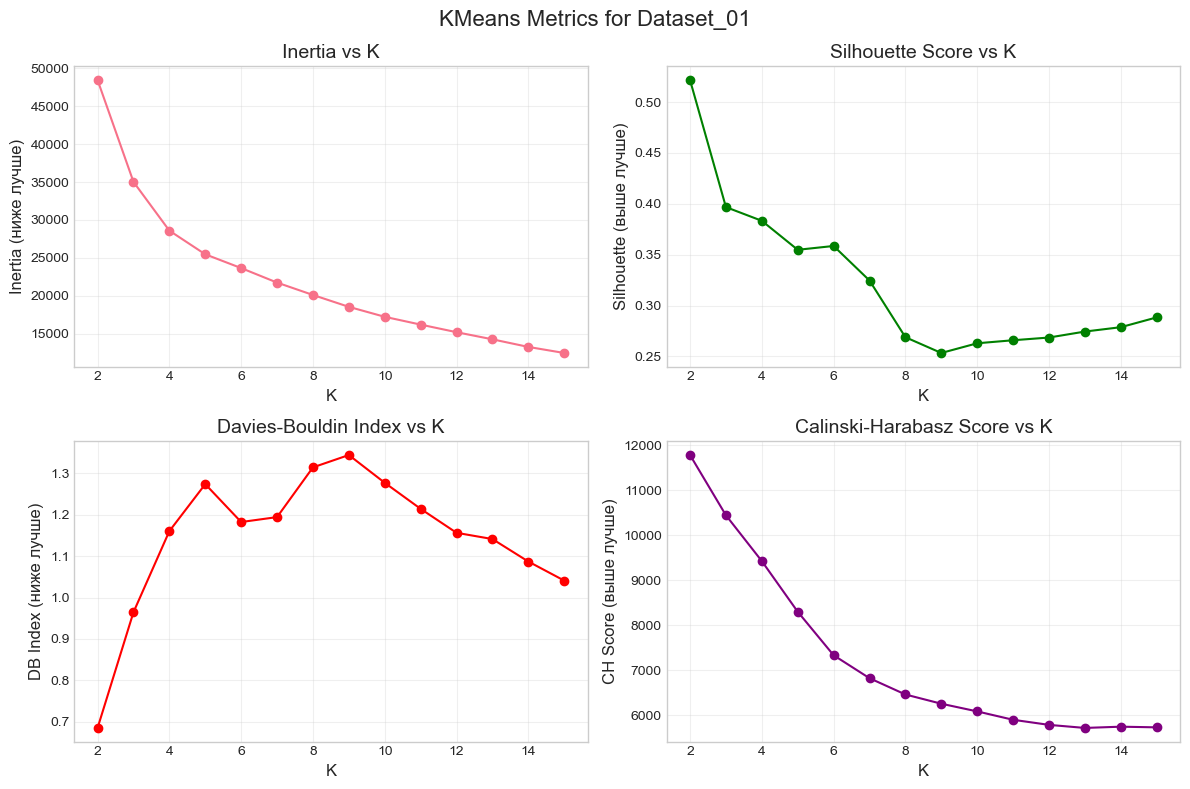


Лучшее K на основе silhouette: 2
Silhouette score: 0.5216

----------------------------------------
DBSCAN анализ
----------------------------------------


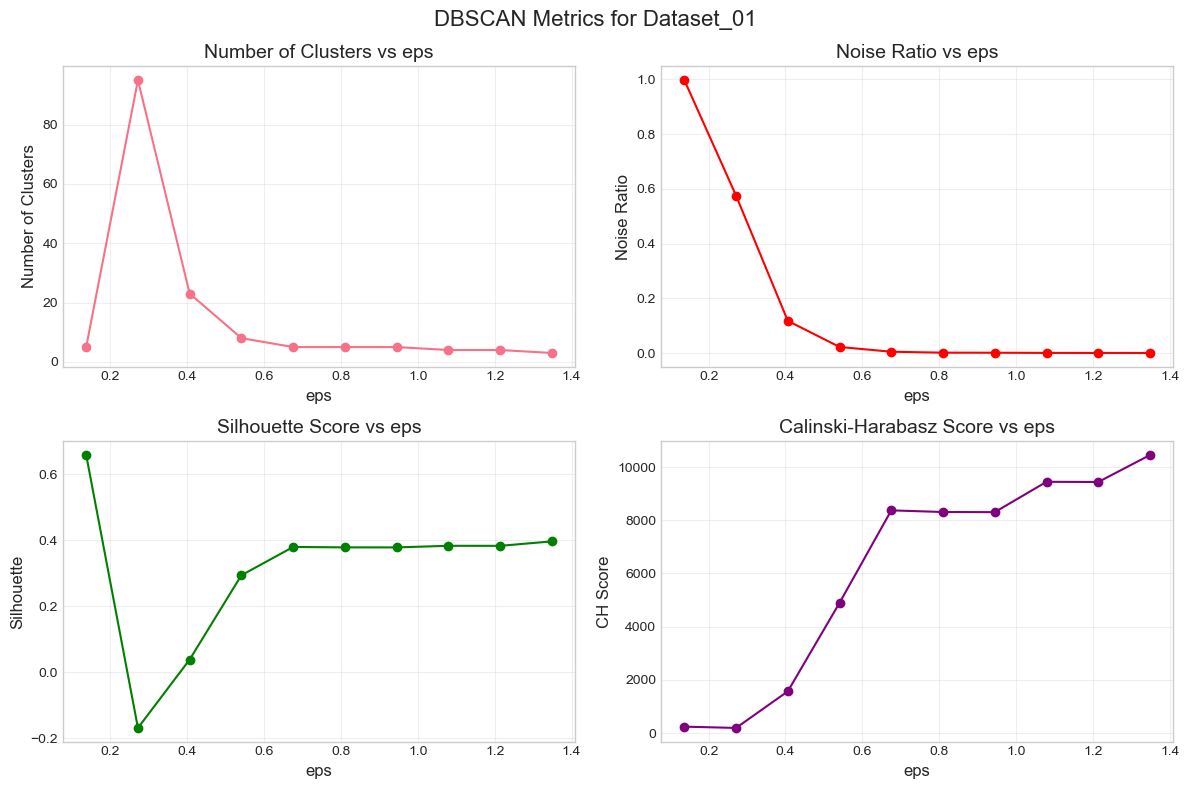


Лучшие параметры DBSCAN:
eps: 0.1369, clusters: 5.0
Silhouette: 0.6587

----------------------------------------
Сравнение метрик
----------------------------------------

KMeans метрики:
  algorithm: KMeans
  n_clusters: 2
  noise_points: 0
  noise_ratio: 0.0000
  silhouette: 0.5216
  davies_bouldin: 0.6853
  calinski_harabasz: 11786.9546

DBSCAN метрики:
  algorithm: DBSCAN
  n_clusters: 5
  noise_points: 11973
  noise_ratio: 0.9978
  silhouette: 0.6587
  davies_bouldin: 0.4550
  calinski_harabasz: 243.4202

----------------------------------------
Визуализация результатов
----------------------------------------


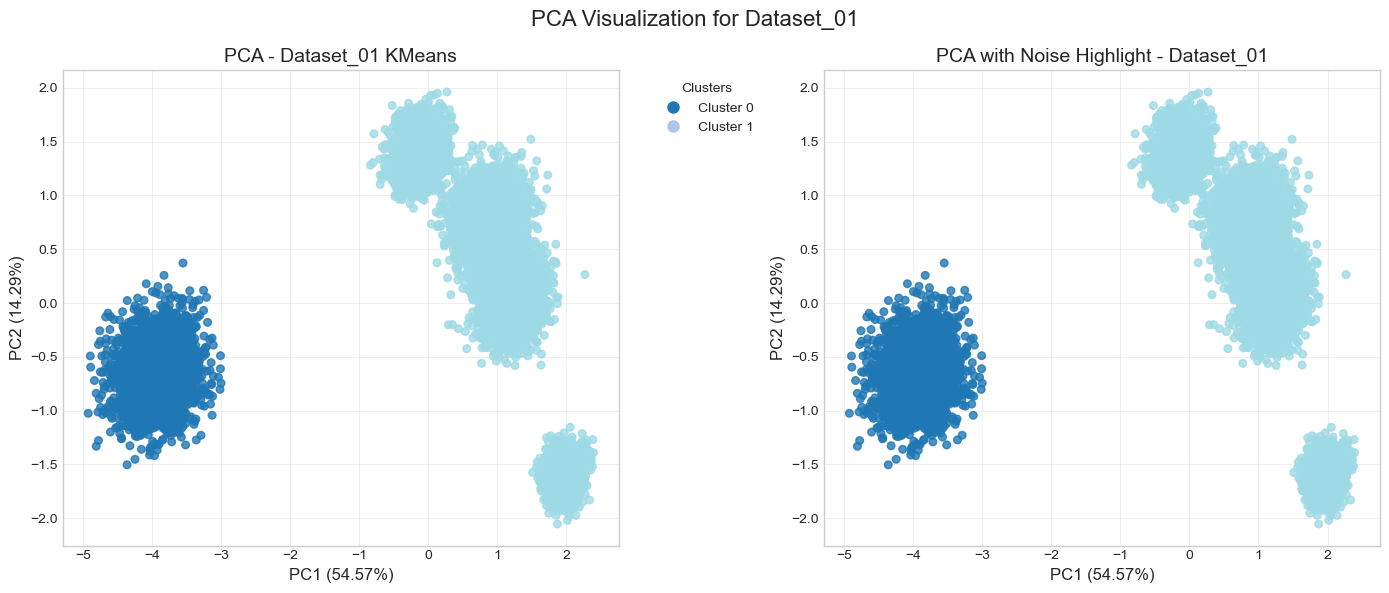

Объясненная дисперсия PCA: 68.86%


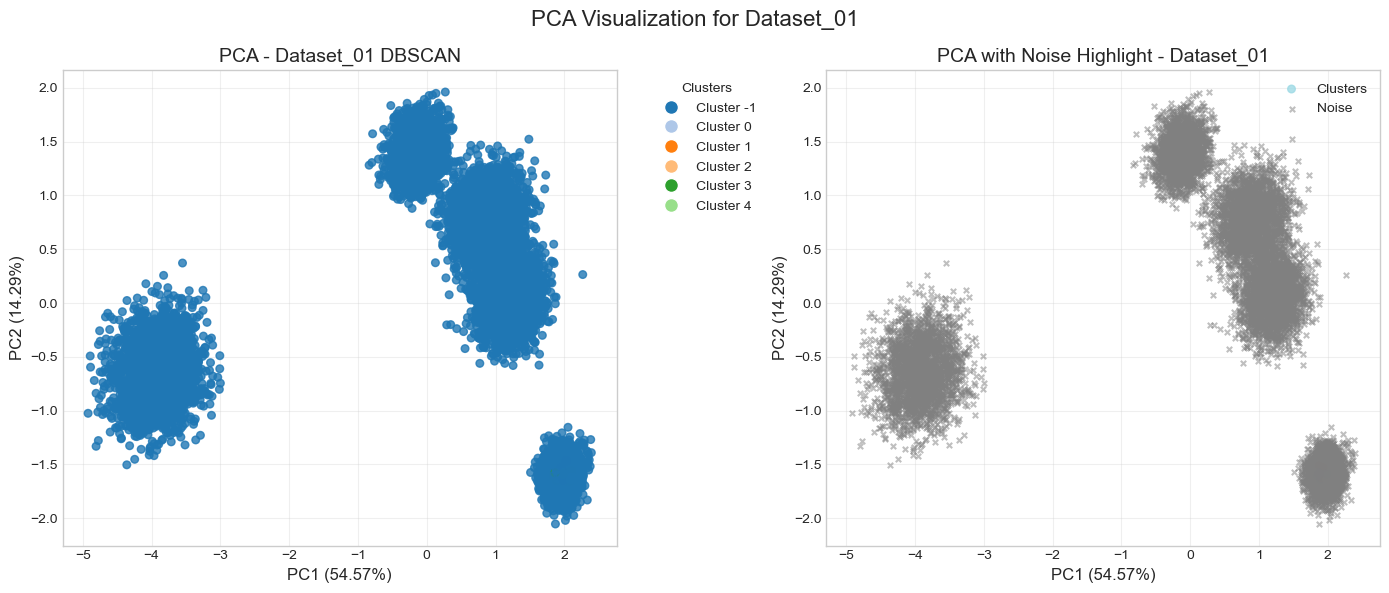

Объясненная дисперсия PCA: 68.86%

----------------------------------------
Выбор лучшего алгоритма для Dataset_01
----------------------------------------
Выбран DBSCAN (silhouette: 0.6587)

----------------------------------------
ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_01
----------------------------------------

Проверка устойчивости KMeans для Dataset_01
Iteration 1: 2 кластеров
Iteration 2: 2 кластеров
Iteration 3: 2 кластеров
Iteration 4: 2 кластеров
Iteration 5: 2 кластеров
ARI между итерацией 1 и 2: 0.0087
ARI между итерацией 1 и 3: -0.0049
ARI между итерацией 1 и 4: 0.0081
ARI между итерацией 1 и 5: 0.0009
ARI между итерацией 2 и 3: -0.0077
ARI между итерацией 2 и 4: 0.0045
ARI между итерацией 2 и 5: 0.0040
ARI между итерацией 3 и 4: 0.0006
ARI между итерацией 3 и 5: -0.0009
ARI между итерацией 4 и 5: -0.0058

Средний ARI: 0.0008
Стандартное отклонение ARI: 0.0054

АНАЛИЗ DATASET 01 ЗАВЕРШЕН


In [62]:
# Словарь для хранения результатов
all_results = {}
best_configs = {}

# АНАЛИЗ DATASET 01

print("\n" + "="*80)
print("НАЧИНАЕМ АНАЛИЗ DATASET 01")
print("="*80)

# 1. Загрузка и EDA
df1 = load_and_explore_dataset('data/S07-hw-dataset-01.csv', 'Dataset_01')

# 2. Препроцессинг
X1 = df1.drop(columns=['sample_id'])
sample_ids1 = df1['sample_id']

preprocessor1 = create_preprocessor(df1.drop(columns=['sample_id']))
X1_processed = preprocessor1.fit_transform(X1)

print(f"\nФорма данных после препроцессинга: {X1_processed.shape}")

# 3. KMeans анализ
print("\n" + "-"*40)
print("KMeans анализ")
print("-"*40)

kmeans_results1 = evaluate_kmeans(X1_processed, 'Dataset_01', k_range=range(2, 16))

# Выбор лучшего K на основе silhouette
best_k_row = kmeans_results1.loc[kmeans_results1['silhouette'].idxmax()]
best_k = int(best_k_row['k'])
print(f"\nЛучшее K на основе silhouette: {best_k}")
print(f"Silhouette score: {best_k_row['silhouette']:.4f}")

# Обучение KMeans с лучшим K
kmeans_best1 = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
labels_kmeans1 = kmeans_best1.fit_predict(X1_processed)

# 4. DBSCAN анализ
print("\n" + "-"*40)
print("DBSCAN анализ")
print("-"*40)

dbscan_results1 = evaluate_dbscan(X1_processed, 'Dataset_01', min_samples=5)

# Выбор лучших параметров DBSCAN
valid_results = dbscan_results1[dbscan_results1['silhouette'].notna() & 
                                (dbscan_results1['n_clusters'] >= 2)]
if not valid_results.empty:
    best_dbscan_row = valid_results.loc[valid_results['silhouette'].idxmax()]
    best_eps = best_dbscan_row['eps']
    print(f"\nЛучшие параметры DBSCAN:")
    print(f"eps: {best_eps:.4f}, clusters: {best_dbscan_row['n_clusters']}")
    print(f"Silhouette: {best_dbscan_row['silhouette']:.4f}")
    
    dbscan_best1 = DBSCAN(eps=best_eps, min_samples=5)
    labels_dbscan1 = dbscan_best1.fit_predict(X1_processed)
else:
    print("DBSCAN не нашел валидных кластеров с заданными параметрами")
    labels_dbscan1 = None

# 5. Расчет метрик
print("\n" + "-"*40)
print("Сравнение метрик")
print("-"*40)

metrics_kmeans1 = calculate_all_metrics(X1_processed, labels_kmeans1, "KMeans")
print("\nKMeans метрики:")
for key, value in metrics_kmeans1.items():
    if value is not None:
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

if labels_dbscan1 is not None:
    metrics_dbscan1 = calculate_all_metrics(X1_processed, labels_dbscan1, "DBSCAN")
    print("\nDBSCAN метрики:")
    for key, value in metrics_dbscan1.items():
        if value is not None:
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# 6. Визуализация лучшего результата
print("\n" + "-"*40)
print("Визуализация результатов")
print("-"*40)

# PCA для KMeans
plot_pca_results(X1_processed, labels_kmeans1, 'Dataset_01', 'KMeans')

# PCA для DBSCAN (если есть валидные кластеры)
if labels_dbscan1 is not None:
    plot_pca_results(X1_processed, labels_dbscan1, 'Dataset_01', 'DBSCAN')

# 7. Выбор лучшего алгоритма
print("\n" + "-"*40)
print("Выбор лучшего алгоритма для Dataset_01")
print("-"*40)

if labels_dbscan1 is not None:
    # Сравниваем silhouette scores
    if metrics_kmeans1['silhouette'] > metrics_dbscan1.get('silhouette', -1):
        print(f"Выбран KMeans (silhouette: {metrics_kmeans1['silhouette']:.4f})")
        best_labels1 = labels_kmeans1
        best_algorithm1 = "KMeans"
        best_params1 = {"n_clusters": best_k}
    else:
        print(f"Выбран DBSCAN (silhouette: {metrics_dbscan1['silhouette']:.4f})")
        best_labels1 = labels_dbscan1
        best_algorithm1 = "DBSCAN"
        best_params1 = {"eps": best_eps, "min_samples": 5}
else:
    print(f"Выбран KMeans (единственный валидный алгоритм)")
    best_labels1 = labels_kmeans1
    best_algorithm1 = "KMeans"
    best_params1 = {"n_clusters": best_k}

# 8. Сохранение результатов
all_results['Dataset_01'] = {
    'KMeans': metrics_kmeans1,
    'DBSCAN': metrics_dbscan1 if labels_dbscan1 is not None else None
}

best_configs['Dataset_01'] = {
    'algorithm': best_algorithm1,
    'parameters': best_params1,
    'n_clusters': int(len(np.unique(best_labels1)) - (1 if -1 in best_labels1 else 0)),
    'silhouette': metrics_kmeans1['silhouette'] if best_algorithm1 == 'KMeans' else metrics_dbscan1.get('silhouette')
}

# Сохранение меток кластеров
labels_df1 = pd.DataFrame({
    'sample_id': sample_ids1,
    'cluster_label': best_labels1
})
labels_df1.to_csv('artifacts/labels/labels_dataset_01.csv', index=False)

# 9. Проверка устойчивости (выполняется один раз для одного датасета)
print("\n" + "-"*40)
print("ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_01")
print("-"*40)

stability_scores1 = stability_check_kmeans(X1_processed, 'Dataset_01', n_iterations=5, k=best_k)

# Сохранение результатов устойчивости
best_configs['Dataset_01']['stability'] = {
    'mean_ari': float(np.mean(stability_scores1)),
    'std_ari': float(np.std(stability_scores1))
}

print("\n" + "="*80)
print("АНАЛИЗ DATASET 01 ЗАВЕРШЕН")
print("="*80)


НАЧИНАЕМ АНАЛИЗ DATASET 02

Анализ датасета: Dataset_02
1. Первые 5 строк:
   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472

2. Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None

3. Базовые статистики:
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     

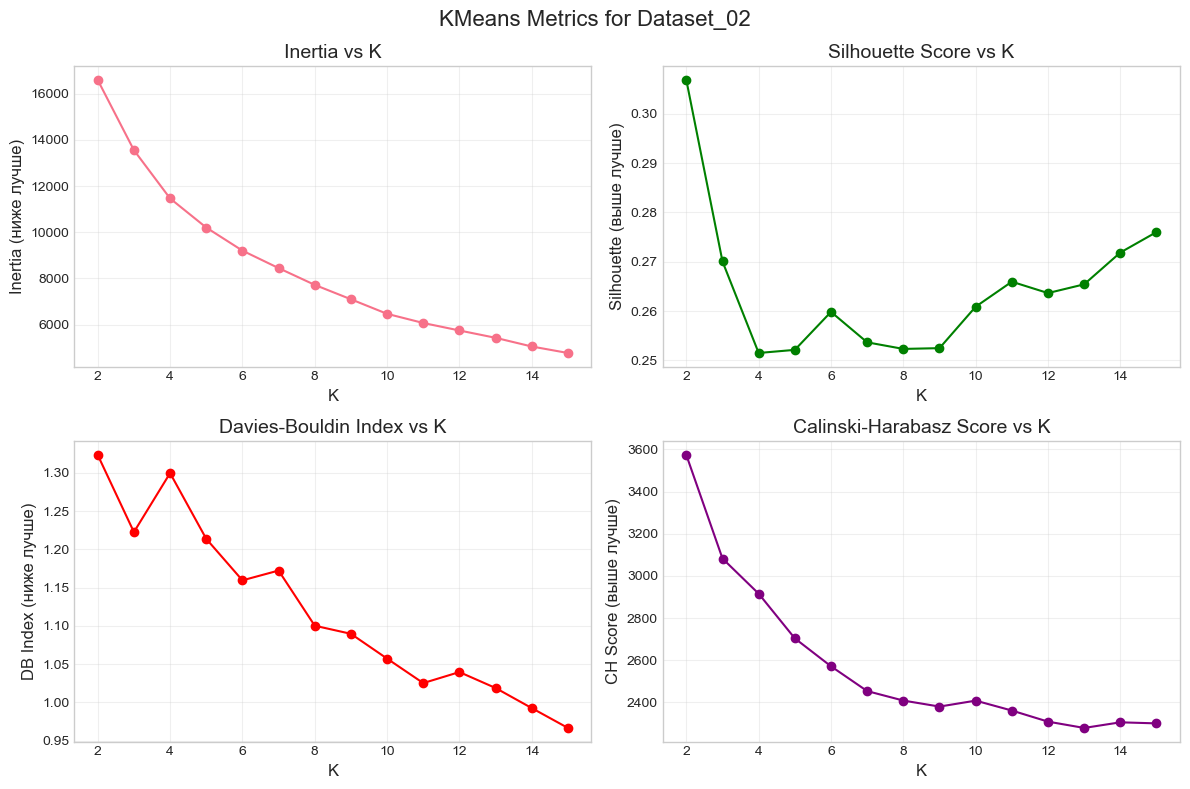


Лучшее K на основе silhouette: 2
Silhouette score: 0.3069

----------------------------------------
DBSCAN анализ
----------------------------------------


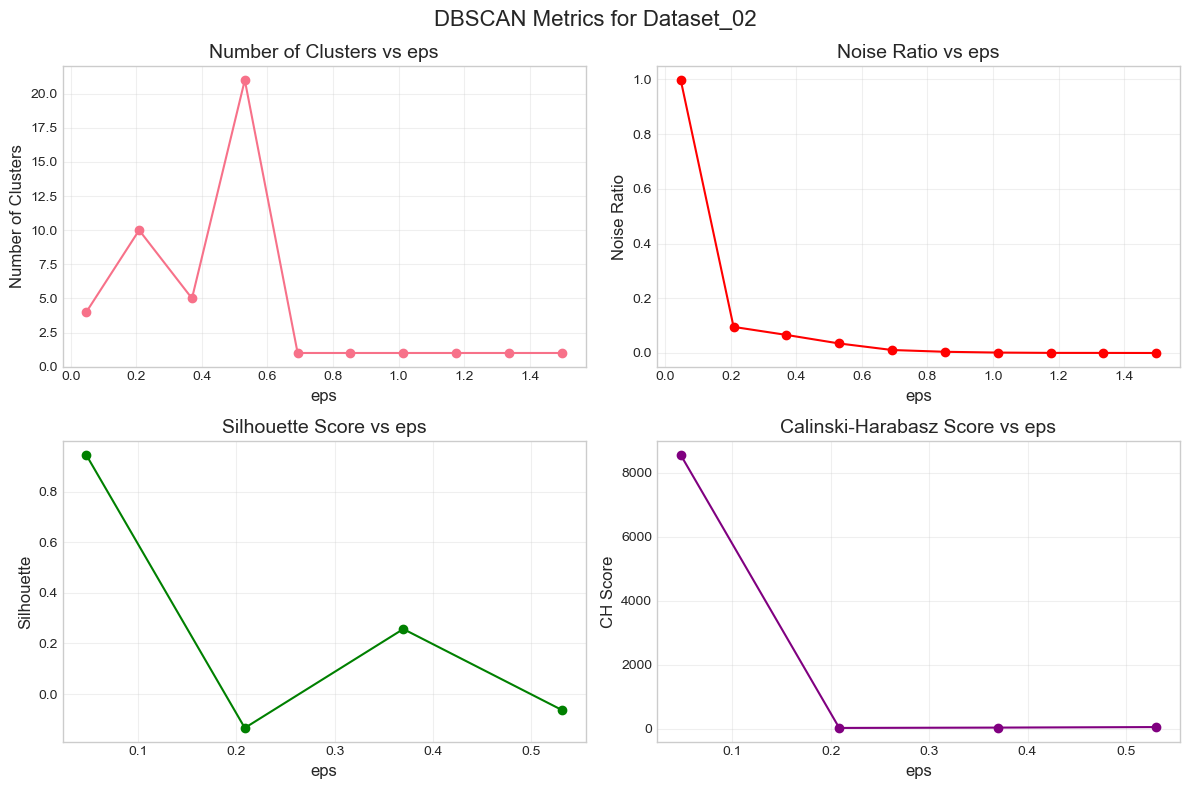


Лучшие параметры DBSCAN:
eps: 0.0474, clusters: 4.0
Silhouette: 0.9442

----------------------------------------
Сравнение метрик
----------------------------------------

KMeans метрики:
  algorithm: KMeans
  n_clusters: 2
  noise_points: 0
  noise_ratio: 0.0000
  silhouette: 0.3069
  davies_bouldin: 1.3235
  calinski_harabasz: 3573.3933

DBSCAN метрики:
  algorithm: DBSCAN
  n_clusters: 4
  noise_points: 7980
  noise_ratio: 0.9975
  silhouette: 0.9442
  davies_bouldin: 0.0697
  calinski_harabasz: 8558.7616

----------------------------------------
Визуализация результатов
----------------------------------------


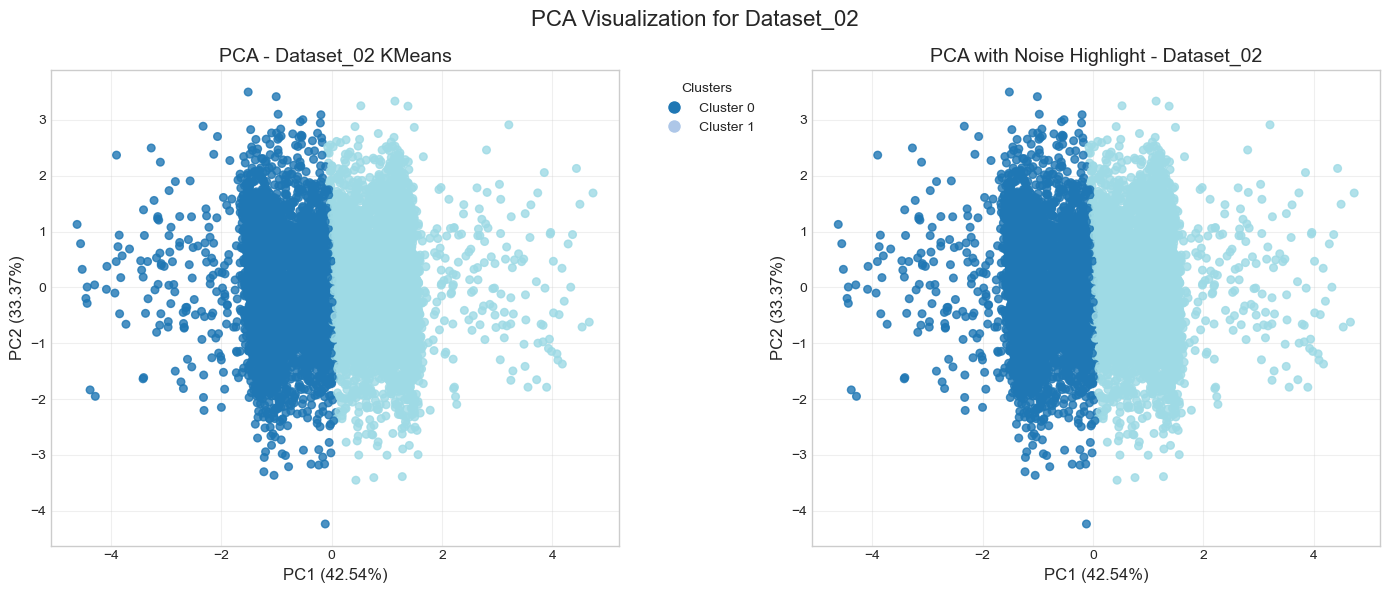

Объясненная дисперсия PCA: 75.91%


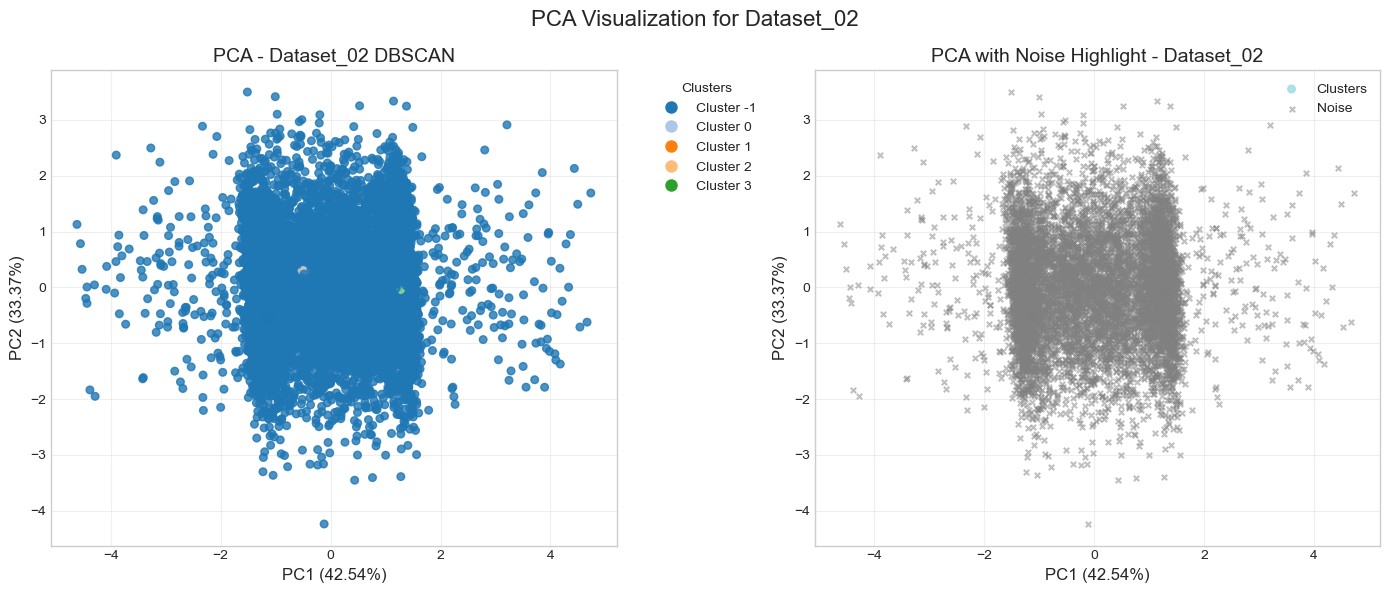

Объясненная дисперсия PCA: 75.91%

----------------------------------------
Выбор лучшего алгоритма для Dataset_02
----------------------------------------
Выбран DBSCAN (silhouette: 0.9442)

----------------------------------------
ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_02
----------------------------------------

Проверка устойчивости KMeans для Dataset_02
Iteration 1: 2 кластеров
Iteration 2: 2 кластеров
Iteration 3: 2 кластеров
Iteration 4: 2 кластеров
Iteration 5: 2 кластеров
ARI между итерацией 1 и 2: 0.0000
ARI между итерацией 1 и 3: 0.0004
ARI между итерацией 1 и 4: 0.0003
ARI между итерацией 1 и 5: 0.0003
ARI между итерацией 2 и 3: -0.0001
ARI между итерацией 2 и 4: 0.0001
ARI между итерацией 2 и 5: -0.0001
ARI между итерацией 3 и 4: -0.0001
ARI между итерацией 3 и 5: -0.0001
ARI между итерацией 4 и 5: -0.0000

Средний ARI: 0.0001
Стандартное отклонение ARI: 0.0002

АНАЛИЗ DATASET 02 ЗАВЕРШЕН


In [63]:
# АНАЛИЗ DATASET 02 (схема аналогична, но с другими параметрами)

print("\n" + "="*80)
print("НАЧИНАЕМ АНАЛИЗ DATASET 02")
print("="*80)

df2 = load_and_explore_dataset('data/S07-hw-dataset-02.csv', 'Dataset_02')

X2 = df2.drop(columns=['sample_id'])
sample_ids2 = df2['sample_id']

preprocessor2 = create_preprocessor(df2.drop(columns=['sample_id']))
X2_processed = preprocessor2.fit_transform(X2)

print(f"\nФорма данных после препроцессинга: {X2_processed.shape}")

# 3. KMeans анализ
print("\n" + "-"*40)
print("KMeans анализ")
print("-"*40)

kmeans_results2 = evaluate_kmeans(X2_processed, 'Dataset_02', k_range=range(2, 16))

# Выбор лучшего K на основе silhouette
best_k_row = kmeans_results2.loc[kmeans_results2['silhouette'].idxmax()]
best_k = int(best_k_row['k'])
print(f"\nЛучшее K на основе silhouette: {best_k}")
print(f"Silhouette score: {best_k_row['silhouette']:.4f}")

# Обучение KMeans с лучшим K
kmeans_best2 = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
labels_kmeans2 = kmeans_best2.fit_predict(X2_processed)

# 4. DBSCAN анализ
print("\n" + "-"*40)
print("DBSCAN анализ")
print("-"*40)

dbscan_results2 = evaluate_dbscan(X2_processed, 'Dataset_02', min_samples=5)

# Выбор лучших параметров DBSCAN
valid_results = dbscan_results2[dbscan_results2['silhouette'].notna() & 
                                (dbscan_results2['n_clusters'] >= 2)]
if not valid_results.empty:
    best_dbscan_row = valid_results.loc[valid_results['silhouette'].idxmax()]
    best_eps = best_dbscan_row['eps']
    print(f"\nЛучшие параметры DBSCAN:")
    print(f"eps: {best_eps:.4f}, clusters: {best_dbscan_row['n_clusters']}")
    print(f"Silhouette: {best_dbscan_row['silhouette']:.4f}")
    
    dbscan_best2 = DBSCAN(eps=best_eps, min_samples=5)
    labels_dbscan2 = dbscan_best2.fit_predict(X2_processed)
else:
    print("DBSCAN не нашел валидных кластеров с заданными параметрами")
    labels_dbscan2 = None

# 5. Расчет метрик
print("\n" + "-"*40)
print("Сравнение метрик")
print("-"*40)

metrics_kmeans2 = calculate_all_metrics(X2_processed, labels_kmeans2, "KMeans")
print("\nKMeans метрики:")
for key, value in metrics_kmeans2.items():
    if value is not None:
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

if labels_dbscan2 is not None:
    metrics_dbscan2 = calculate_all_metrics(X2_processed, labels_dbscan2, "DBSCAN")
    print("\nDBSCAN метрики:")
    for key, value in metrics_dbscan2.items():
        if value is not None:
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# 6. Визуализация лучшего результата
print("\n" + "-"*40)
print("Визуализация результатов")
print("-"*40)

# PCA для KMeans
plot_pca_results(X2_processed, labels_kmeans2, 'Dataset_02', 'KMeans')

# PCA для DBSCAN (если есть валидные кластеры)
if labels_dbscan2 is not None:
    plot_pca_results(X2_processed, labels_dbscan2, 'Dataset_02', 'DBSCAN')

# 7. Выбор лучшего алгоритма
print("\n" + "-"*40)
print("Выбор лучшего алгоритма для Dataset_02")
print("-"*40)

if labels_dbscan2 is not None:
    # Сравниваем silhouette scores
    if metrics_kmeans2['silhouette'] > metrics_dbscan2.get('silhouette', -1):
        print(f"Выбран KMeans (silhouette: {metrics_kmeans2['silhouette']:.4f})")
        best_labels2 = labels_kmeans2
        best_algorithm2 = "KMeans"
        best_params2 = {"n_clusters": best_k}
    else:
        print(f"Выбран DBSCAN (silhouette: {metrics_dbscan2['silhouette']:.4f})")
        best_labels2 = labels_dbscan2
        best_algorithm2 = "DBSCAN"
        best_params2 = {"eps": best_eps, "min_samples": 5}
else:
    print(f"Выбран KMeans (единственный валидный алгоритм)")
    best_labels2 = labels_kmeans2
    best_algorithm2 = "KMeans"
    best_params2 = {"n_clusters": best_k}

# 8. Сохранение результатов
all_results['Dataset_02'] = {
    'KMeans': metrics_kmeans2,
    'DBSCAN': metrics_dbscan2 if labels_dbscan2 is not None else None
}

best_configs['Dataset_02'] = {
    'algorithm': best_algorithm2,
    'parameters': best_params2,
    'n_clusters': int(len(np.unique(best_labels2)) - (1 if -1 in best_labels2 else 0)),
    'silhouette': metrics_kmeans2['silhouette'] if best_algorithm2 == 'KMeans' else metrics_dbscan2.get('silhouette')
}

# Сохранение меток кластеров
labels_df2 = pd.DataFrame({
    'sample_id': sample_ids2,
    'cluster_label': best_labels2
})
labels_df2.to_csv('artifacts/labels/labels_dataset_02.csv', index=False)

# 9. Проверка устойчивости (выполняется один раз для одного датасета)
print("\n" + "-"*40)
print("ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_02")
print("-"*40)

stability_scores2 = stability_check_kmeans(X2_processed, 'Dataset_02', n_iterations=5, k=best_k)

# Сохранение результатов устойчивости
best_configs['Dataset_02']['stability'] = {
    'mean_ari': float(np.mean(stability_scores2)),
    'std_ari': float(np.std(stability_scores2))
}

print("\n" + "="*80)
print("АНАЛИЗ DATASET 02 ЗАВЕРШЕН")
print("="*80)


НАЧИНАЕМ АНАЛИЗ DATASET 03

Анализ датасета: Dataset_03
1. Первые 5 строк:
   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899

2. Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None

3. Базовые статистики:
          sample_id            x1            x2        f_corr       f_noise
count  15000.000000  15000.000000 

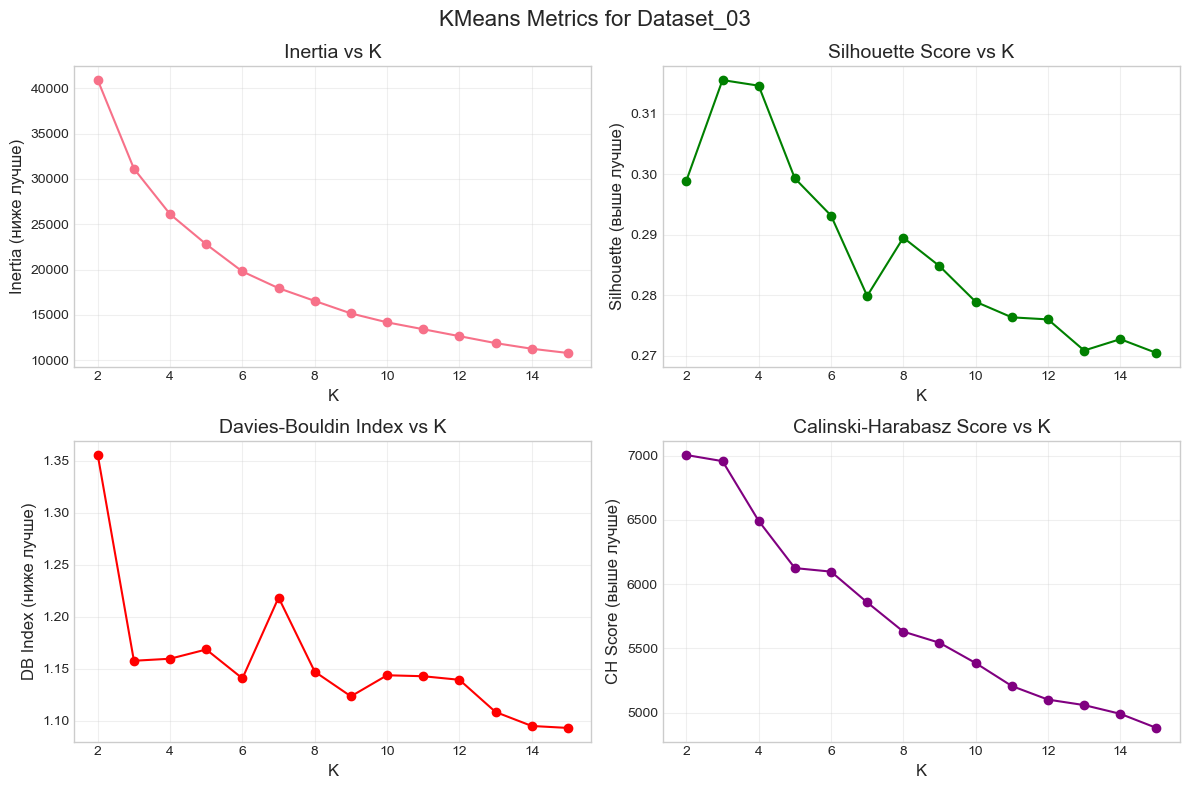


Лучшее K на основе silhouette: 3
Silhouette score: 0.3155

----------------------------------------
DBSCAN анализ
----------------------------------------


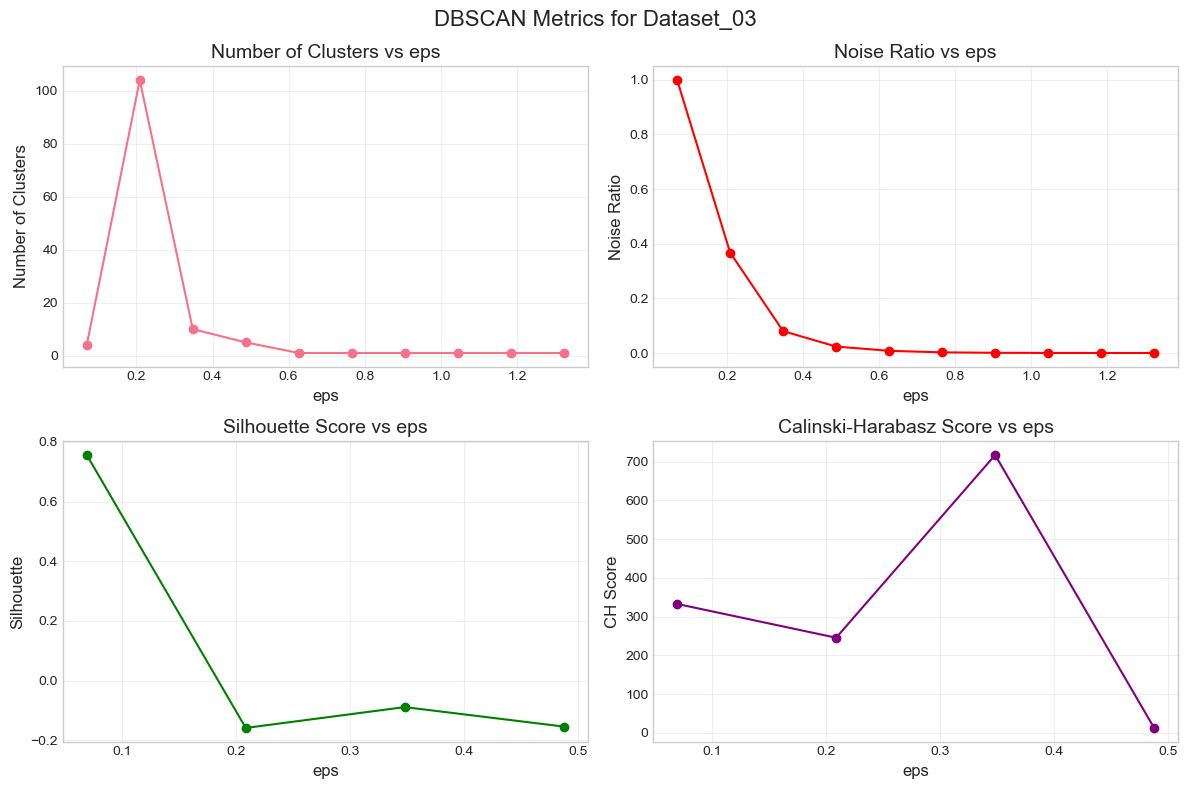


Лучшие параметры DBSCAN:
eps: 0.0693, clusters: 4.0
Silhouette: 0.7557

----------------------------------------
Сравнение метрик
----------------------------------------

KMeans метрики:
  algorithm: KMeans
  n_clusters: 3
  noise_points: 0
  noise_ratio: 0.0000
  silhouette: 0.3155
  davies_bouldin: 1.1577
  calinski_harabasz: 6957.1626

DBSCAN метрики:
  algorithm: DBSCAN
  n_clusters: 4
  noise_points: 14978
  noise_ratio: 0.9985
  silhouette: 0.7557
  davies_bouldin: 0.3024
  calinski_harabasz: 332.7765

----------------------------------------
Визуализация результатов
----------------------------------------


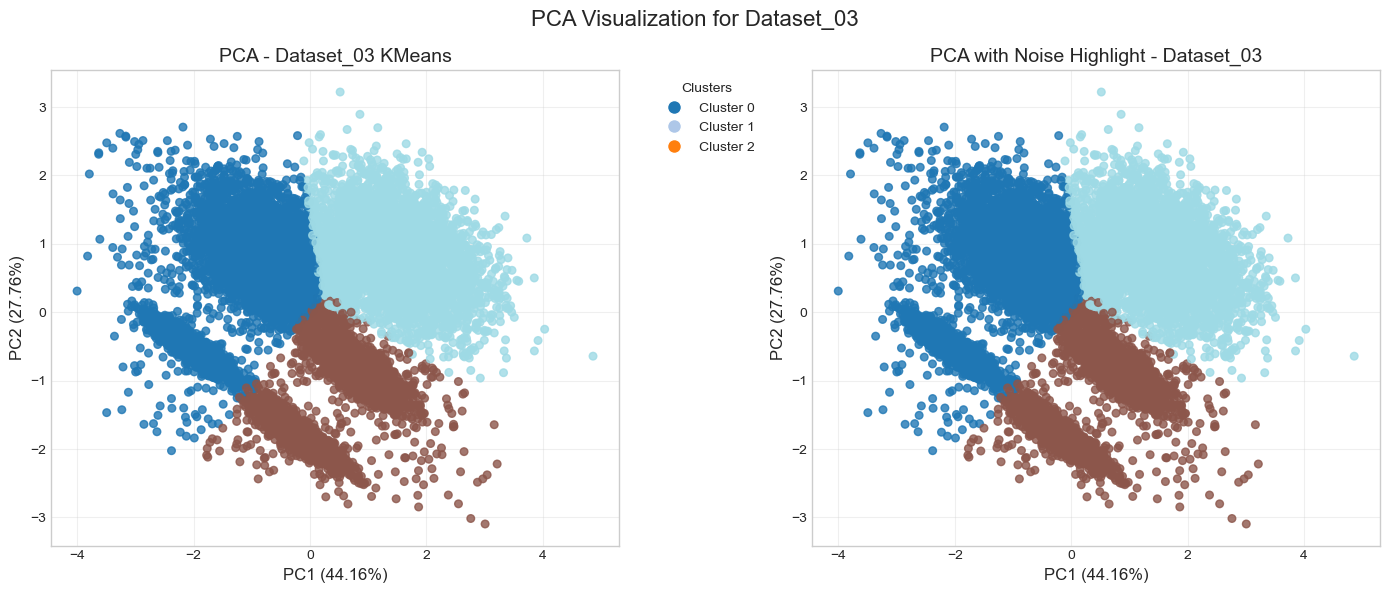

Объясненная дисперсия PCA: 71.92%


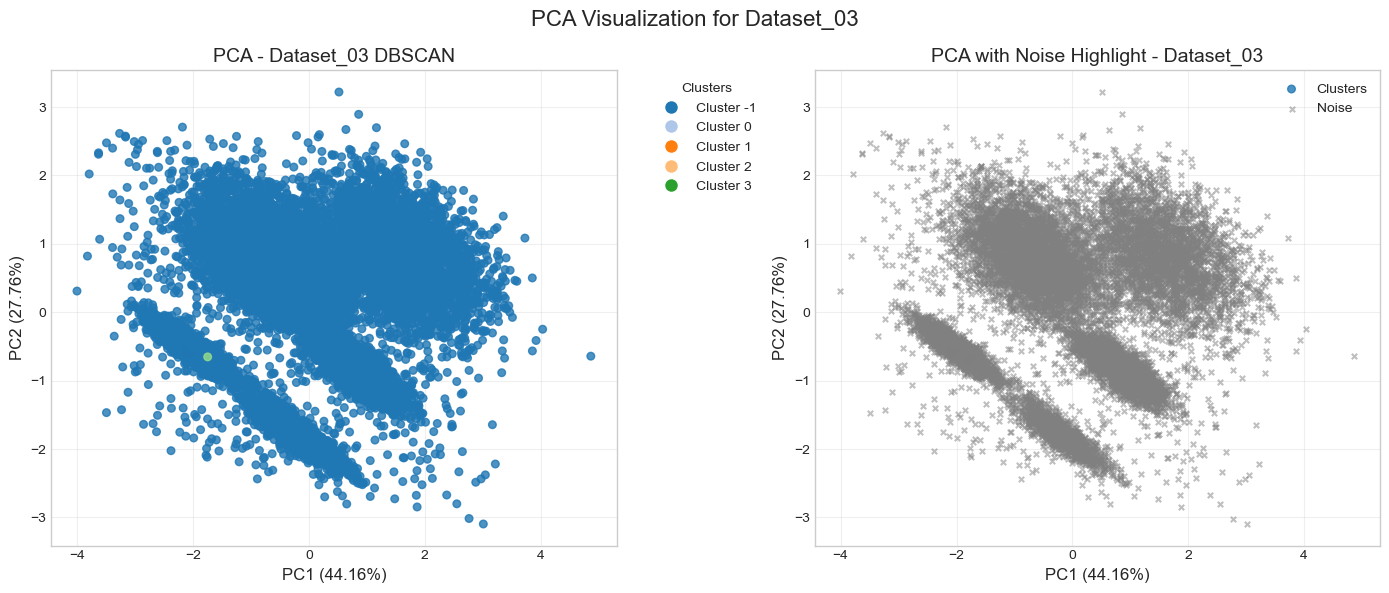

Объясненная дисперсия PCA: 71.92%

----------------------------------------
Выбор лучшего алгоритма для Dataset_03
----------------------------------------
Выбран DBSCAN (silhouette: 0.7557)

----------------------------------------
ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_03
----------------------------------------

Проверка устойчивости KMeans для Dataset_03
Iteration 1: 3 кластеров
Iteration 2: 3 кластеров
Iteration 3: 3 кластеров
Iteration 4: 3 кластеров
Iteration 5: 3 кластеров
ARI между итерацией 1 и 2: 0.0005
ARI между итерацией 1 и 3: -0.0001
ARI между итерацией 1 и 4: -0.0004
ARI между итерацией 1 и 5: 0.0000
ARI между итерацией 2 и 3: -0.0005
ARI между итерацией 2 и 4: 0.0004
ARI между итерацией 2 и 5: -0.0001
ARI между итерацией 3 и 4: -0.0001
ARI между итерацией 3 и 5: 0.0004
ARI между итерацией 4 и 5: 0.0003

Средний ARI: 0.0000
Стандартное отклонение ARI: 0.0003

АНАЛИЗ DATASET 03 ЗАВЕРШЕН


In [64]:
# АНАЛИЗ DATASET 03 (схема аналогична, но с другими параметрами)

print("\n" + "="*80)
print("НАЧИНАЕМ АНАЛИЗ DATASET 03")
print("="*80)

df3 = load_and_explore_dataset('data/S07-hw-dataset-03.csv', 'Dataset_03')

X3 = df3.drop(columns=['sample_id'])
sample_ids3 = df3['sample_id']

preprocessor3 = create_preprocessor(df3.drop(columns=['sample_id']))
X3_processed = preprocessor3.fit_transform(X3)

print(f"\nФорма данных после препроцессинга: {X3_processed.shape}")

# 3. KMeans анализ
print("\n" + "-"*40)
print("KMeans анализ")
print("-"*40)

kmeans_results3 = evaluate_kmeans(X3_processed, 'Dataset_03', k_range=range(2, 16))

# Выбор лучшего K на основе silhouette
best_k_row = kmeans_results3.loc[kmeans_results3['silhouette'].idxmax()]
best_k = int(best_k_row['k'])
print(f"\nЛучшее K на основе silhouette: {best_k}")
print(f"Silhouette score: {best_k_row['silhouette']:.4f}")

# Обучение KMeans с лучшим K
kmeans_best3 = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
labels_kmeans3 = kmeans_best3.fit_predict(X3_processed)

# 4. DBSCAN анализ
print("\n" + "-"*40)
print("DBSCAN анализ")
print("-"*40)

dbscan_results3 = evaluate_dbscan(X3_processed, 'Dataset_03', min_samples=5)

# Выбор лучших параметров DBSCAN
valid_results = dbscan_results3[dbscan_results3['silhouette'].notna() & 
                                (dbscan_results3['n_clusters'] >= 2)]
if not valid_results.empty:
    best_dbscan_row = valid_results.loc[valid_results['silhouette'].idxmax()]
    best_eps = best_dbscan_row['eps']
    print(f"\nЛучшие параметры DBSCAN:")
    print(f"eps: {best_eps:.4f}, clusters: {best_dbscan_row['n_clusters']}")
    print(f"Silhouette: {best_dbscan_row['silhouette']:.4f}")
    
    dbscan_best3 = DBSCAN(eps=best_eps, min_samples=5)
    labels_dbscan3 = dbscan_best3.fit_predict(X3_processed)
else:
    print("DBSCAN не нашел валидных кластеров с заданными параметрами")
    labels_dbscan3 = None

# 5. Расчет метрик
print("\n" + "-"*40)
print("Сравнение метрик")
print("-"*40)

metrics_kmeans3 = calculate_all_metrics(X3_processed, labels_kmeans3, "KMeans")
print("\nKMeans метрики:")
for key, value in metrics_kmeans3.items():
    if value is not None:
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

if labels_dbscan3 is not None:
    metrics_dbscan3 = calculate_all_metrics(X3_processed, labels_dbscan3, "DBSCAN")
    print("\nDBSCAN метрики:")
    for key, value in metrics_dbscan3.items():
        if value is not None:
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# 6. Визуализация лучшего результата
print("\n" + "-"*40)
print("Визуализация результатов")
print("-"*40)

# PCA для KMeans
plot_pca_results(X3_processed, labels_kmeans3, 'Dataset_03', 'KMeans')

# PCA для DBSCAN (если есть валидные кластеры)
if labels_dbscan3 is not None:
    plot_pca_results(X3_processed, labels_dbscan3, 'Dataset_03', 'DBSCAN')

# 7. Выбор лучшего алгоритма
print("\n" + "-"*40)
print("Выбор лучшего алгоритма для Dataset_03")
print("-"*40)

if labels_dbscan3 is not None:
    # Сравниваем silhouette scores
    if metrics_kmeans3['silhouette'] > metrics_dbscan3.get('silhouette', -1):
        print(f"Выбран KMeans (silhouette: {metrics_kmeans3['silhouette']:.4f})")
        best_labels3 = labels_kmeans3
        best_algorithm3 = "KMeans"
        best_params3 = {"n_clusters": best_k}
    else:
        print(f"Выбран DBSCAN (silhouette: {metrics_dbscan3['silhouette']:.4f})")
        best_labels3 = labels_dbscan3
        best_algorithm3 = "DBSCAN"
        best_params3 = {"eps": best_eps, "min_samples": 5}
else:
    print(f"Выбран KMeans (единственный валидный алгоритм)")
    best_labels3 = labels_kmeans3
    best_algorithm3 = "KMeans"
    best_params3 = {"n_clusters": best_k}

# 8. Сохранение результатов
all_results['Dataset_03'] = {
    'KMeans': metrics_kmeans3,
    'DBSCAN': metrics_dbscan3 if labels_dbscan3 is not None else None
}

best_configs['Dataset_03'] = {
    'algorithm': best_algorithm3,
    'parameters': best_params3,
    'n_clusters': int(len(np.unique(best_labels3)) - (1 if -1 in best_labels3 else 0)),
    'silhouette': metrics_kmeans3['silhouette'] if best_algorithm3 == 'KMeans' else metrics_dbscan3.get('silhouette')
}

# Сохранение меток кластеров
labels_df3 = pd.DataFrame({
    'sample_id': sample_ids3,
    'cluster_label': best_labels3
})
labels_df3.to_csv('artifacts/labels/labels_dataset_03.csv', index=False)

# 9. Проверка устойчивости (выполняется один раз для одного датасета)
print("\n" + "-"*40)
print("ПРОВЕРКА УСТОЙЧИВОСТИ ДЛЯ DATASET_03")
print("-"*40)

stability_scores3 = stability_check_kmeans(X3_processed, 'Dataset_03', n_iterations=5, k=best_k)

# Сохранение результатов устойчивости
best_configs['Dataset_03']['stability'] = {
    'mean_ari': float(np.mean(stability_scores3)),
    'std_ari': float(np.std(stability_scores3))
}

print("\n" + "="*80)
print("АНАЛИЗ DATASET 03 ЗАВЕРШЕН")
print("="*80)

In [65]:
# СОХРАНЕНИЕ АРТЕФАКТОВ

print("СОХРАНЕНИЕ АРТЕФАКТОВ")

# Сохранение метрик
with open('artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

# Сохранение лучших конфигураций
with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("\nАртефакты сохранены:")
print("+ metrics_summary.json")
print("+ best_configs.json")
print("+ Папка labels/ с CSV файлами кластеров")
print("+ Папка figures/ с графиками")

# Выводы

print("\n" + "="*80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО АНАЛИЗУ")
print("="*80)

for dataset, config in best_configs.items():
    print(f"\n{dataset}:")
    print(f"  Лучший алгоритм: {config['algorithm']}")
    print(f"  Параметры: {config['parameters']}")
    print(f"  Количество кластеров: {config['n_clusters']}")
    print(f"  Silhouette score: {config.get('silhouette', 'N/A'):.4f}")
    if 'stability' in config:
        print(f"  Устойчивость (средний ARI): {config['stability']['mean_ari']:.4f}")

print("ВЫПОЛНЕНИЕ ЗАДАНИЯ ЗАВЕРШЕНО")


СОХРАНЕНИЕ АРТЕФАКТОВ

Артефакты сохранены:
+ metrics_summary.json
+ best_configs.json
+ Папка labels/ с CSV файлами кластеров
+ Папка figures/ с графиками

ИТОГОВЫЕ ВЫВОДЫ ПО АНАЛИЗУ

Dataset_01:
  Лучший алгоритм: DBSCAN
  Параметры: {'eps': 0.13688614049480202, 'min_samples': 5}
  Количество кластеров: 5
  Silhouette score: 0.6587
  Устойчивость (средний ARI): 0.0008

Dataset_02:
  Лучший алгоритм: DBSCAN
  Параметры: {'eps': 0.04741959953014622, 'min_samples': 5}
  Количество кластеров: 4
  Silhouette score: 0.9442
  Устойчивость (средний ARI): 0.0001

Dataset_03:
  Лучший алгоритм: DBSCAN
  Параметры: {'eps': 0.06925555234762452, 'min_samples': 5}
  Количество кластеров: 4
  Silhouette score: 0.7557
  Устойчивость (средний ARI): 0.0000
ВЫПОЛНЕНИЕ ЗАДАНИЯ ЗАВЕРШЕНО
